## Problem Statement

**Microsoft Stock Price Prediction using LSTM models**

This pipeline seeks to predict stock prices for Microsoft to help company's discover the future value of company stock. It also would help individuals who want to invest in a companies stock to make the decision of whether to invest or not as most individuals seek to invest in companies with high grow potential. Artificial Intelligence, Robotics and Technology are some developments that might affect the stock prices as we move forward. Therefore, companies like Microsoft are eye catching companies as they are one of the companies focused on utizing technology and artificial intelligence. The stock price prediction of Microsoft should therefore be analyzed and watched as it might have some growth potential.


13 March 1986 to 9 December 2023

Dataset Source: https://finance.yahoo.com/quote/MSFT/history?period1=755395200&period2=1702080000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

## Importing Libraries

This stage seeks to load all the required libraries that will be used in this pipeline.

In [18]:
import os
import datetime
import pandas as pd
import numpy as np
import sklearn.metrics
import sklearn.preprocessing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

## Loading Dataset

This stage seeks to load the Microsoft dataset collected from Yahoo website https://finance.yahoo.com/quote/MSFT/history?period1=755395200&period2=1702080000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true.

In [19]:
#Read out dataset
data = pd.read_csv(r"Microsoft_Stock_Prices_Dataset.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061889,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


## Data Exploration

This stage seeks to review the loaded dataset by checking for any missing values, data types for features in each label column and review the data shape.

In [20]:
#prints out information on the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9513 entries, 0 to 9512
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9513 non-null   object 
 1   Open       9513 non-null   float64
 2   High       9513 non-null   float64
 3   Low        9513 non-null   float64
 4   Close      9513 non-null   float64
 5   Adj Close  9513 non-null   float64
 6   Volume     9513 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 520.4+ KB


In [21]:
#prints out the total number of datapoints (279,753) with 12 columns
data.shape

(9513, 7)

In [22]:
#Checks if there is any missing value
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [23]:
#Prints the data type of the date column to check whether it is in the correct datetime framework
data['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9508    2023-12-04
9509    2023-12-05
9510    2023-12-06
9511    2023-12-07
9512    2023-12-08
Name: Date, Length: 9513, dtype: object

##Dataset Preprocessing

This stage seeks to clean the dataset and also create the target and feature labels. This particular pipeline will only make use of the close column and drop all other column to simplify the pipeline. Four new column labels are created by shifting the closing price by a day four times. The fourth shifted column will be used as the target for this pipeline and the features will be the remaining 3 days shifted columns plus the initial close column. This stage also formats the date string format to datetime format.

In [24]:
#Converts the date in the string format to datetime by defining a function that splits the year, month and date
def string_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

datetime_obj = string_to_datetime('1986-03-13')
datetime_obj

datetime.datetime(1986, 3, 13, 0, 0)

In [25]:
#Drop columns that will not be used to simplify the pipeline, leaving the date and close columns.

data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
data.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


In [26]:
#Applys the define datetime function to the whole dataset
#The last printed out row reveals that the data type has been converted to datetime data type.
data['Date'] = data['Date'].apply(string_to_datetime)
data['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9508   2023-12-04
9509   2023-12-05
9510   2023-12-06
9511   2023-12-07
9512   2023-12-08
Name: Date, Length: 9513, dtype: datetime64[ns]

In [27]:
#Sets the date to index to avoid errors when scaling the features
data = data.set_index('Date')
data.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


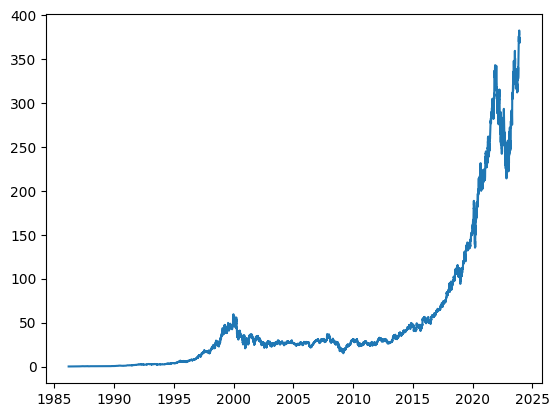

In [28]:
#Plot the target label to illustrate the movement of the closing stock price
plt.plot(data.index, data['Close'])

In [29]:
#Creates four new target columns based on the closing stock on the previous day
#It assigns the values of the close column shifted by 1, 2, 3 and 4 day/s, subesequently Target-3, Target-2, Target-1 and Target.
#The "Target" label in this pipeline will be the last column that is predicted based on the closing price on the last 4 days.
data["1_Day_Past_Close"] = data["Close"].shift(-1)
data["2_Day_Past_Close"] = data["Close"].shift(-2)
data["3_Day_Past_Close"] = data["Close"].shift(-3)
data["Target_Close"] = data["Close"].shift(-4)

#Rename the close column to initial close
data.rename(columns={"Close": "Initial_Close"}, inplace=True)
data.head()

,Initial_Close,1_Day_Past_Close,2_Day_Past_Close,3_Day_Past_Close,Target_Close
Date,,,,,
1986-03-13,0.097222,0.100694,0.102431,0.099826,0.098090
1986-03-14,0.100694,0.102431,0.099826,0.098090,0.095486
1986-03-17,0.102431,0.099826,0.098090,0.095486,0.092882
1986-03-18,0.099826,0.098090,0.095486,0.092882,0.090278
1986-03-19,0.098090,0.095486,0.092882,0.090278,0.092014


In [30]:
#Checks to review null values after the creation of new target values based on previous closing price.
data.tail(5)

,Initial_Close,1_Day_Past_Close,2_Day_Past_Close,3_Day_Past_Close,Target_Close
Date,,,,,
2023-12-04,369.140015,372.519989,368.799988,370.950012,374.230011
2023-12-05,372.519989,368.799988,370.950012,374.230011,NaN
2023-12-06,368.799988,370.950012,374.230011,NaN,NaN
2023-12-07,370.950012,374.230011,NaN,NaN,NaN
2023-12-08,374.230011,NaN,NaN,NaN,NaN


In [31]:
#Drops the last four rows with null values
data = data.drop(data.tail(4).index)
data.tail(5)

,Initial_Close,1_Day_Past_Close,2_Day_Past_Close,3_Day_Past_Close,Target_Close
Date,,,,,
2023-11-28,382.700012,378.850006,378.910004,374.510010,369.140015
2023-11-29,378.850006,378.910004,374.510010,369.140015,372.519989
2023-11-30,378.910004,374.510010,369.140015,372.519989,368.799988
2023-12-01,374.510010,369.140015,372.519989,368.799988,370.950012
2023-12-04,369.140015,372.519989,368.799988,370.950012,374.230011


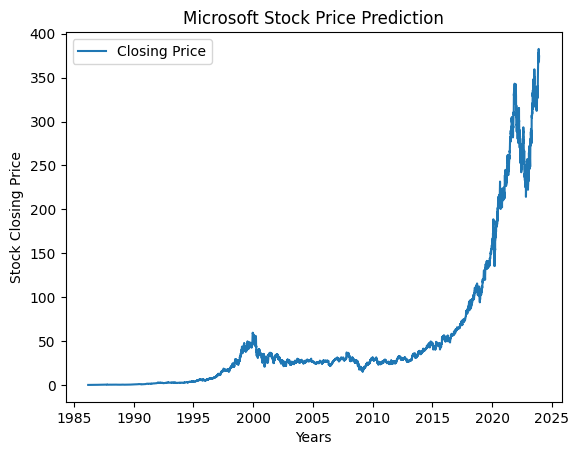

In [34]:
#Illustrates a flow chart of the target column (Stock Closing Price Forecast)

plt.plot(data.index, data["Target_Close"], label='Closing Price')  #Plots the test set in green

plt.xlabel("Years")
plt.ylabel("Stock Closing Price")
plt.title("Microsoft Stock Price Prediction")
plt.legend()

plt.show()

## Splitting the Dataset

This section seeks to split the whole dataset into three sections: training, validation and test datasets using the pandas library.  To train the model on the initial portion of the data, validate it on the following portion, and then test it on the remaining data. The exact proportions (70%, 15%, 15% in this case) can be adjusted based on the specific requirements and characteristics of the dataset. Splits the date index to match the train, validation and test set and then illustrate the split dataset on a graph chart.

In [ ]:
#The training set starts from the beginning of the dataset
train_start_index = 0

#The validation set starts from 70% of the total number of rows in the dataset
validation_start_index = int(data.shape[0] * 0.70)

#Index marks the starting point of the test set
test_start_index = int(data.shape[0] * 0.85)

#Creates new dataframe from the loaded dataset using the pandas library
df_train = data.iloc[train_start_index:validation_start_index]
df_validation = data.iloc[validation_start_index:test_start_index]
df_test = data.iloc[test_start_index:]

#Drops the target label from the dataset so as to set the remaining columns as features to be used in the prediction
x_train = df_train.drop("Target_Close", axis=1)
x_validation = df_validation.drop("Target_Close", axis=1)
x_test = df_test.drop("Target_Close", axis=1)

#Sets the y variable equal to the target label and splits the y variable into train, validation and test sets
y_train = df_train["Target_Close"]
y_validation = df_validation["Target_Close"]  # Use correct y-values for validation set
y_test = df_test["Target_Close"]

# Print the sizes of the sets
print("The train size is: ", x_train.shape, y_train.shape)
print("The validation size is: ", x_validation.shape, y_validation.shape)
print("The test size is: ", x_test.shape, y_test.shape)

The train size is:  (6656, 4) (6656,)
The validation size is:  (1426, 4) (1426,)
The test size is:  (1427, 4) (1427,)


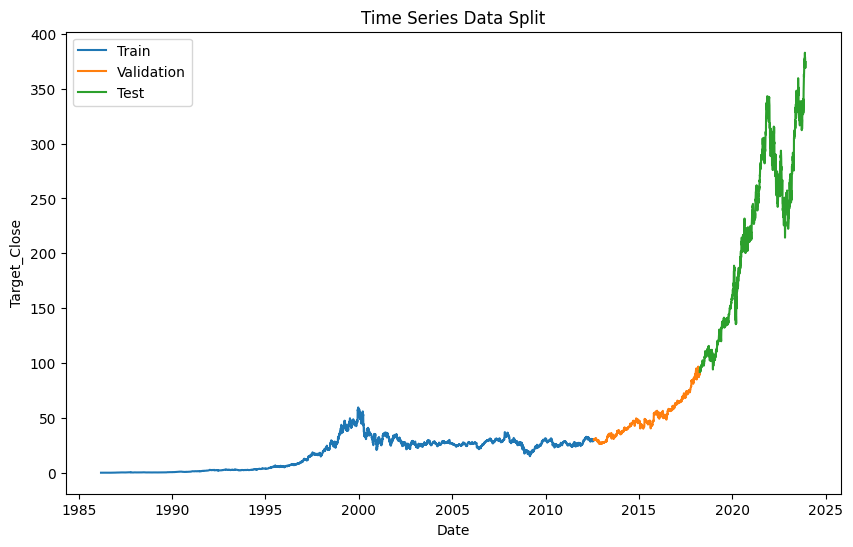

In [ ]:
#Splits the data using the percentages to fix into the date.index splits
q_70 = int(len(data) * 0.7)
q_85 = int(len(data) * 0.85)

#Splits the dates into train, validation and test dates
dates_train = data.index[:q_70]
dates_val = data.index[q_70:q_85]
dates_test = data.index[q_85:]

# Plots the figure below
plt.figure(figsize=(10, 6))

plt.plot(dates_train, y_train, label='Train')  #Plots the train set in blus
plt.plot(dates_val, y_validation[:len(dates_val)], label='Validation')  #Plots the validation set in orange
plt.plot(dates_test, y_test, label='Test')  #Plots the test set in green

plt.xlabel('Date')
plt.ylabel('Target_Close')
plt.title('Time Series Data Split')
plt.legend()

plt.show()


##Standardizing Features

 This stage seeks to ensure that the features are scaled to have a similar range of values by transforming all features to have zero mean and unit variance. To maintain consistence the same scaler is used to transform parameters for the train, validation and test datasets. This is beneficial when training certain learning algorithms.
  

In [ ]:
#The immediate below code is used to standardizes the features of the dataset in all three split datasets
scaler = sklearn.preprocessing.StandardScaler()

#Transforms the x train data using the scaler
x_train = scaler.fit_transform(x_train)

#Transforms the x validation data using the scaler
x_validation = scaler.fit_transform(x_validation)

#Transforms the x test data using the scaler
x_test = scaler.transform(x_test)

In [ ]:
#Prints the x_train shape
x_train.shape

(6656, 4)

In [ ]:
#Prints x_train values to check is they have been scaled
print(x_train)

[[-1.25234315 -1.25248806 -1.25275774 -1.25334076]
 [-1.25209253 -1.25236266 -1.25294581 -1.2534661 ]
 [-1.25196714 -1.25255072 -1.25307113 -1.2536541 ]
 ...
 [ 0.88019359  0.86766211  0.8630599   0.84690177]
 [ 0.86792219  0.86333082  0.84717738  0.88733239]
 [ 0.86359118  0.84744924  0.8876057   0.90177199]]


##Building the Model

Used the LSTM model to train the model with multiple changes of the hyperparameters, a table at the end of the pipeline shows which hyperparameters were adjusted and which model performed better. The table highlights all iterations run and uses the Loss value, MSE and test graph to help review the performance of the model. As the loss values descends, the performance of the model gets better. However, it is worth ending that despite having a low value of the loss value there is still a significant gap between the test actual and predicted values. This indicates that there is still more exploring that can be done to the pipeline to try and increase the performance of the algorithm.

In [ ]:
#Compiles a time series forecasting model using the TensorFlow and Keras library
model = Sequential([layers.Input((4, 1)),      #Adds shape(4, 1), 4 being the 4 shifted days and 1 being one feature for the univariate forecasting
                    layers.LSTM(64),                      #Adds an LSTM layer with 64 units
                    layers.Dense(32, activation='relu'),  #First dense layer with 32 units and ReLU activation function
                    layers.Dense(32, activation='relu'),  #Second dense layer with 32 units and ReLU activation function
                    layers.Dense(1)])                     #The output layer with a single unit as pipeline is only forecasting one label

#Compiles the optimizer, seeks to minimize the loss function of mse and specifies the mean squared error that should be minimized
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 32)                1056      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20065 (78.38 KB)
Trainable params: 20065 (78.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Early stopping seeks to prevent overfitting and save training time. Sets the callback function with hyperparameters val_loss, min_delta=0 and patience=5. The Min_delta sets the minimum change in the monitored metric to qualify as an improvement. The patience parameter determines the number of epochs with no improvement after which training will be stopped.

In [ ]:
#Determines the number of epochs with no improvement after which training will be stopped
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

#Fits the model into the train and validation data with 400 iterations over the entire training dataset
#Early Stopping monitors the validation loss and stop training early if there is no improvement for a specified number of epochs.
model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=400, shuffle=False, callbacks=[es_callback])


Epoch 1/400
208/208 [==============================] - 1s 7ms/step - loss: 1.3005 - mean_absolute_error: 0.8512 - val_loss: 1082.3621 - val_mean_absolute_error: 32.6003
Epoch 2/400
208/208 [==============================] - 1s 6ms/step - loss: 1.2147 - mean_absolute_error: 0.8138 - val_loss: 1087.6984 - val_mean_absolute_error: 32.6894
Epoch 3/400
208/208 [==============================] - 1s 5ms/step - loss: 1.1390 - mean_absolute_error: 0.7540 - val_loss: 1094.1986 - val_mean_absolute_error: 32.7972
Epoch 4/400
208/208 [==============================] - 1s 4ms/step - loss: 1.0480 - mean_absolute_error: 0.7039 - val_loss: 1099.1016 - val_mean_absolute_error: 32.8741
Epoch 5/400
208/208 [==============================] - 1s 4ms/step - loss: 0.9963 - mean_absolute_error: 0.6743 - val_loss: 1104.0801 - val_mean_absolute_error: 32.9527
Epoch 6/400
208/208 [==============================] - 1s 4ms/step - loss: 0.9696 - mean_absolute_error: 0.6461 - val_loss: 1107.4374 - val_mean_absolute_e

##Testing the Model

Train Predictions - Not far of the observed actual train values, the algorithm does a good job of training the model in the pipeline.

Validation Predicitions - Not so good however, both the predicted validation value and actual validation values are moving in the same direction (increasing).

Test Predictions - Not good, the predicted test value and actual test values and significantly far apart and moving in oppsite directions. This indicates that in as much as the model algorithm is working well on the train dataset it is not doing the same for the validation and test dataset. This could imply that maybe there was some form of overfitting in the pipeline or there is need for more pipeline exploration.

208/208 [==============================] - 0s 2ms/step


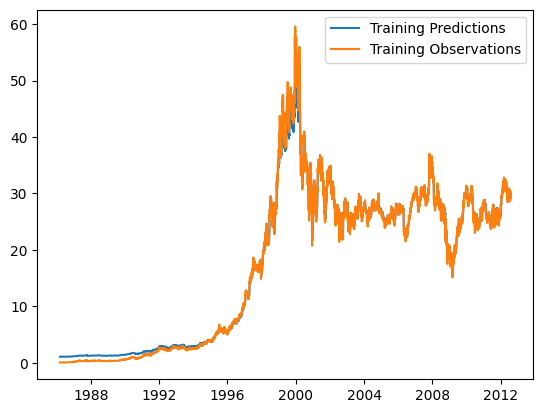

In [ ]:
#One-dimensional array containing the predicted values for the target variable based on the input features of the training set
train_predict = model.predict(x_train).flatten()

#Plots the train predictions and actual observations
plt.plot(dates_train, train_predict)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

45/45 [==============================] - 1s 2ms/step


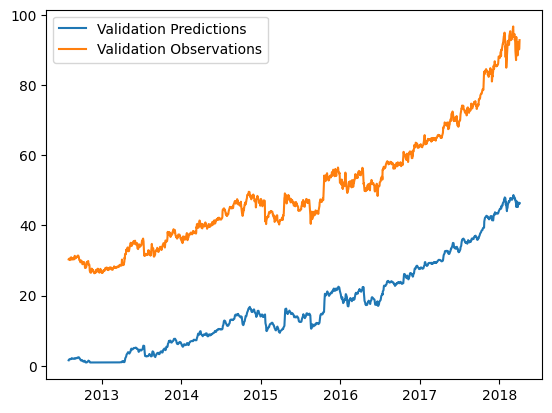

In [ ]:
#One-dimensional array containing the predicted values for the target variable based on the input features of the validation set
val_predictions = model.predict(x_validation).flatten()

#Plots the validation predictions and actual obeservation
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_validation)
plt.legend(['Validation Predictions', 'Validation Observations'])

45/45 [==============================] - 0s 3ms/step


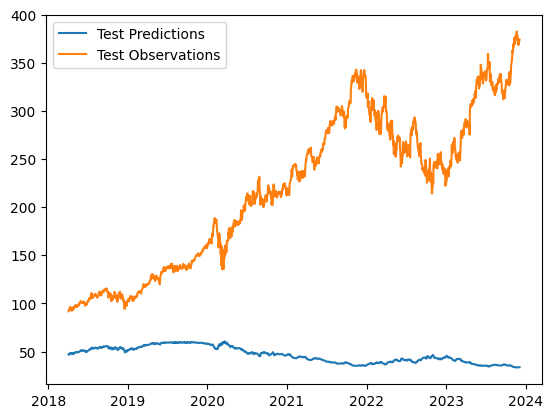

In [ ]:
#One-dimensional array containing the predicted values for the target variable based on the input features of the test set
test_predict=model.predict(x_test)

#Plots the validation predictions and actual obeservation
plt.plot(dates_test, test_predict)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

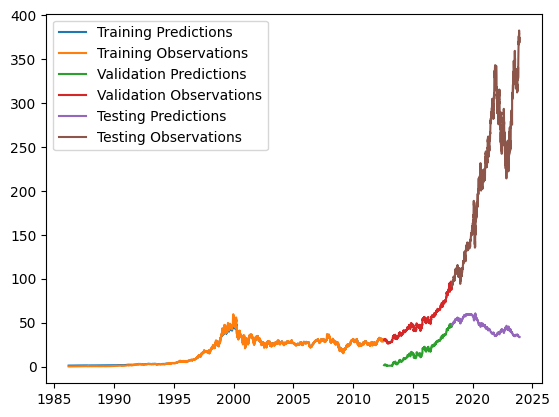

In [ ]:
#Plots the predicted and actual value graphs for all three datasets, train, validation and test sets.
plt.plot(dates_train, train_predict)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_validation)
plt.plot(dates_test, test_predict)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

##Insights Gathered

In conclusion, it was obeserved that despite the model having a reduced loss and MSE value, the model did not perform well on the test and validation sets possibly indicating some overfitting in the pipeline as the model performed really well on the train set. Another point to note is that the dataset could reqiure some more exploration, for example, in the data preprocessing some original label columns could be kept to serve as addition features that could be more favourable and improve the pipeline.

**Implications of the results for the business problem**

This pipepline will not perform well on other datasets as the test evaluation did not perform really well. As indicated, there is still need to re-evaluate and explore the pipeline.

**Data-driven recommendations for solving the initial business problem**

With more time to explore the pipeline, LSTM models can be used to review different pipeline iterations and explore what could possibly work before deeming the LSTM models not useful for the business problem.


**Model Explainable**

The model is explainable to business people, if graphs are utilized as data visuals to explain the performance of the model.



The table below highlights the iterations run in the pipeline to review the performance of the model. As the loss and MSE value descend, the pipeline's performance also improves.


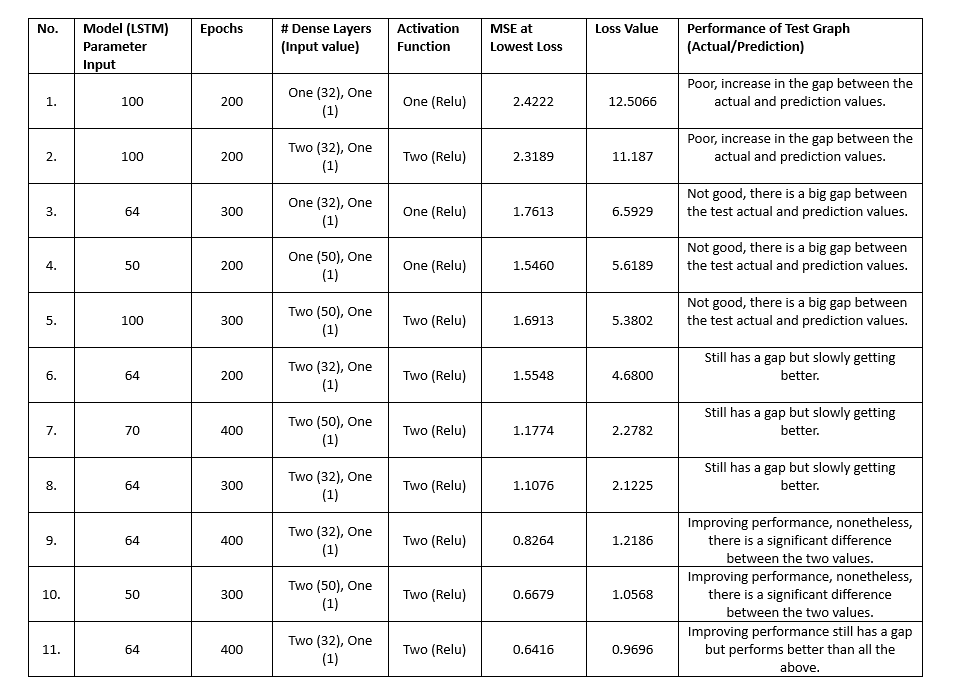

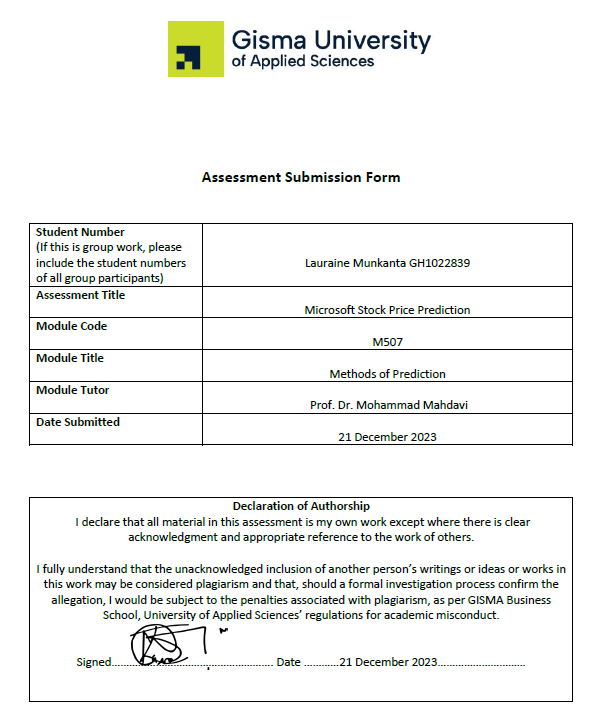

In [16]:
!pip install nbconvert

In [36]:
!jupyter nbconvert Assessment_GH1022839_Methods_of_Prediction.ipynb --to html

[NbConvertApp] Converting notebook Assessment_GH1022839_Methods_of_Prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 916549 bytes to Assessment_GH1022839_Methods_of_Prediction.html
